**About Dataset**

The ChatGPT App Reviews dataset is a comprehensive collection of user reviews from the ChatGPT mobile app on iOS, capturing valuable insights and sentiments. The dataset enables the understanding of user satisfaction, evaluation of app performance, and identification of emerging patterns.

**The way data was collected**

Scraping ChatGPT reviews on App Store

**Ideas for using this dataset**

Sentiment analysis
What makes the application receive 1-star and 5-star
Note - It was last updated on July 26th 2023

In [ ]:
pip install spacy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.util import bigrams, everygrams, ngrams
from nltk.tokenize import (
    word_tokenize,
    sent_tokenize)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from tqdm.notebook import tqdm
tqdm.pandas()
from spacy.lang.en import English

from wordcloud import (
    WordCloud,
    STOPWORDS,
    ImageColorGenerator)

# Preprosessing

In [315]:
data = pd.read_csv('/content/chatgpt_reviews.csv')

In [316]:
display(data.sample(10))

,date,title,review,rating
51,2023-05-23 12:58:18,General feed back and UI Improvements,Please consider adding the following functiona...,5
1478,2023-05-28 16:48:31,Thank you,🙌🙏,5
1022,2023-07-22 06:54:11,Not good,- Messages often don’t go through\n- Slower th...,3
158,2023-05-18 19:32:50,Amazing! 10/10,This thing was a lifesaver for my quick assign...,5
942,2023-05-19 02:22:31,FINALLY!,I’ve been waiting for months for this! Simple ...,5
1491,2023-05-19 02:28:51,Hooray!,"Great app, Apple Shortcuts are need to make th...",5
1160,2023-05-26 11:58:46,Version for iPad,Will there be a iPad version in the future?,4
1537,2023-05-19 05:37:46,It’s too difficult to sign in,"So much limitation , why you set up so many re...",1
1780,2023-05-21 07:45:59,Please support ipad OS！,As the title said.,4
614,2023-06-02 16:00:14,Urgent updates,"Share! Unless I’m missing it, there doesn’t se...",3


In [317]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2292 entries, 0 to 2291
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    2292 non-null   object
 1   title   2292 non-null   object
 2   review  2292 non-null   object
 3   rating  2292 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 71.8+ KB


In [318]:
data.isna().sum()

date      0
title     0
review    0
rating    0
dtype: int64

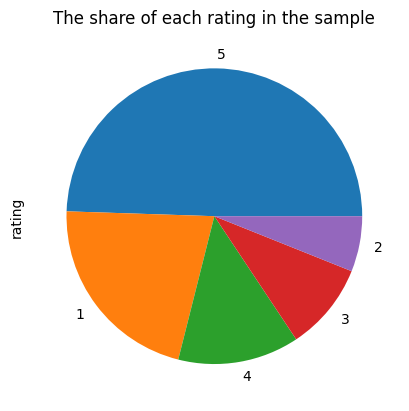

In [319]:
data['rating'].value_counts().plot(kind='pie');
plt.title('The share of each rating in the sample');

In [320]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

In [321]:
data.duplicated().sum()

0

In [322]:
print(data['date'].min())
print(data['date'].max())

2023-05-18 15:43:36
2023-07-25 01:25:35


There are dates in 3 mounth

In [323]:
data['day_of_week'] = data['date'].apply(lambda time: time.dayofweek)
data['hour'] = data['date'].apply(lambda time: time.hour)
data['month'] =  data['date'].apply(lambda time: time.month).astype('str')

In [324]:
data['month'] = data['month'].replace('5', 'May')
data['month'] = data['month'].replace('6', 'June')
data['month'] = data['month'].replace('7', 'July')

# Research analysis

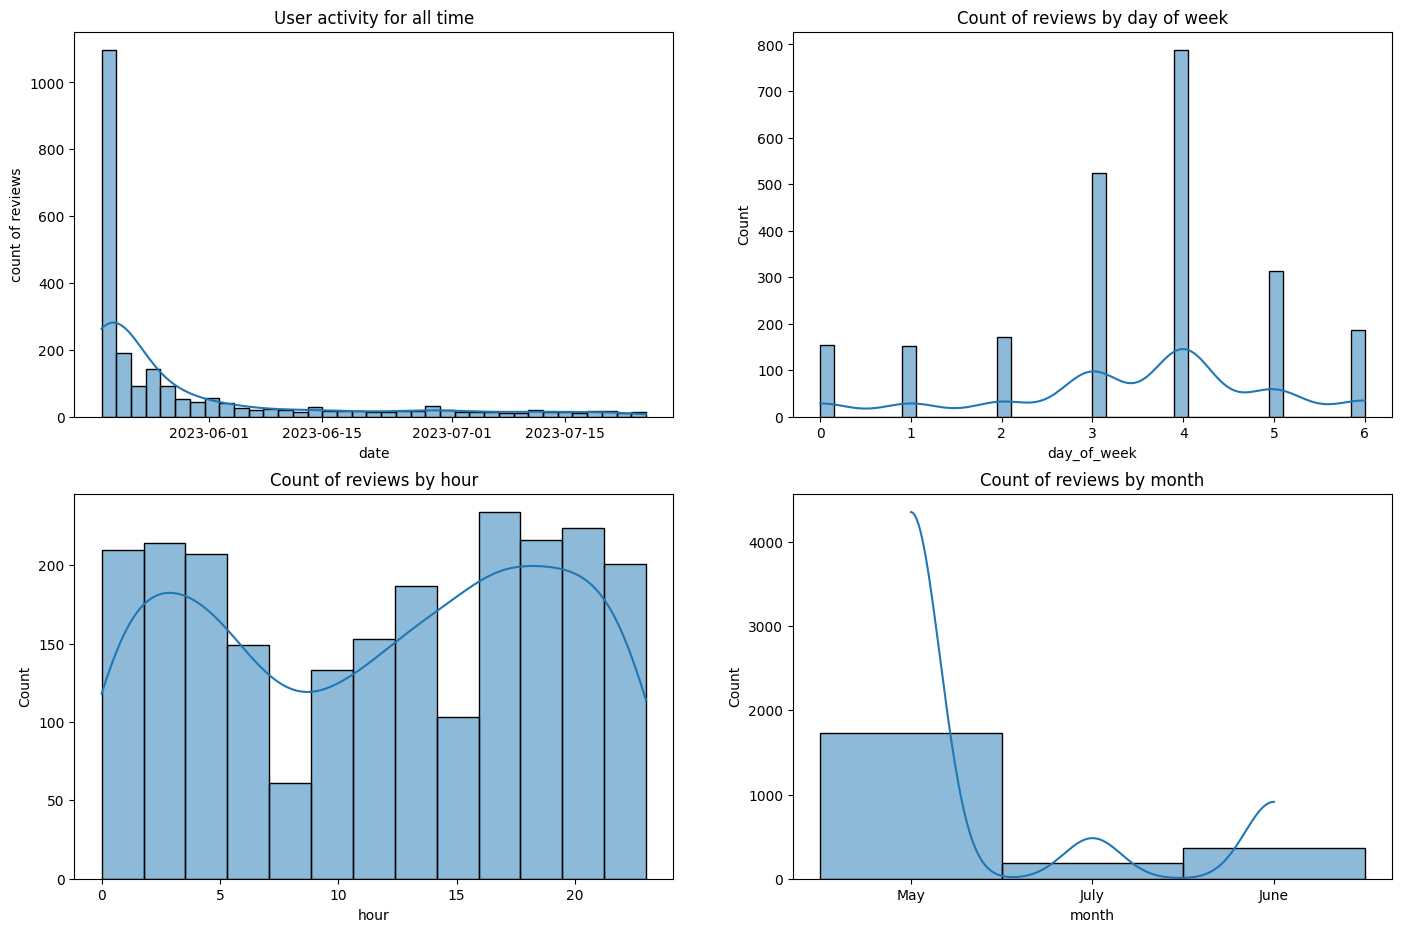

In [137]:
plt.figure(figsize = (17, 11));

plt.subplot(2, 2, 1)
plt.title('User activity for all time');
sns.histplot(data, x='date', kde=True);
plt.ylabel('count of reviews')

plt.subplot(2, 2, 2)
sns.histplot(data, x = 'day_of_week', kde=True);
plt.title('Count of reviews by day of week');

plt.subplot(2, 2, 3)
sns.histplot(data, x = 'hour', kde=True);
plt.title('Count of reviews by hour')

plt.subplot(2, 2, 4)
sns.histplot(data, x = 'month', kde=True);
plt.title('Count of reviews by month')

plt.show()

In [247]:
x1 = list(data[data['month'] == 'May']['day_of_week'])
x2 = list(data[data['month'] == 'June']['day_of_week'])

x3 = list(data[data['month'] == 'May']['hour'])
x4 = list(data[data['month'] == 'July']['hour'])

colors = ['#E69F00', '#56B4E9']
names = ['May', 'July']

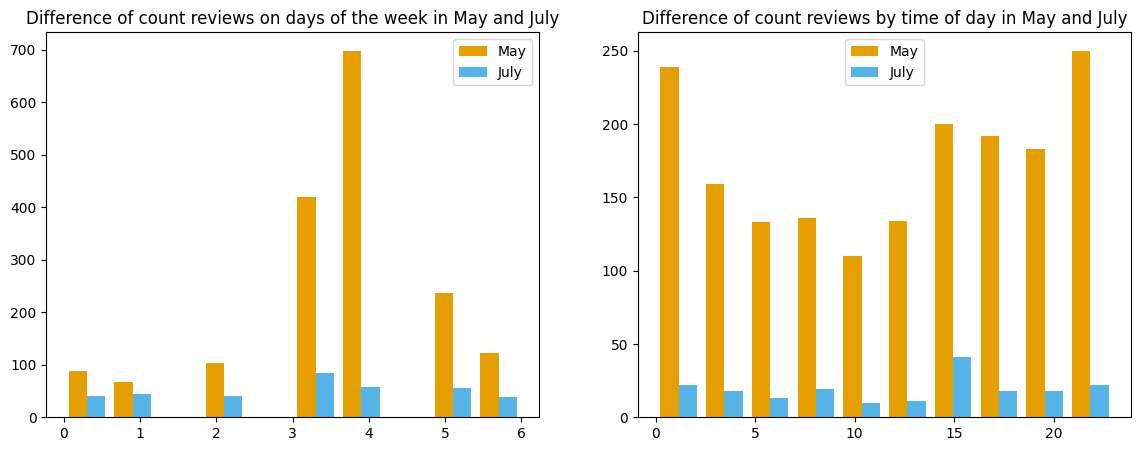

In [248]:
plt.figure(figsize = (14, 5))

plt.subplot(1, 2, 1)
plt.title('Difference of count reviews on days of the week in May and July')
plt.hist([x1, x2], color = colors, label=names)
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Difference of count reviews by time of day in May and July')
plt.hist([x3, x4], color = colors, label=names)
plt.legend()

plt.show()

**Most of the reviews were published in May. Moreover, people were more willing to leave reviews in the morning and evening. The most popular day for reviews is Friday (the second half of the week as a whole). Most likely, this is due to less workload these days and hours and the availability of free time.**

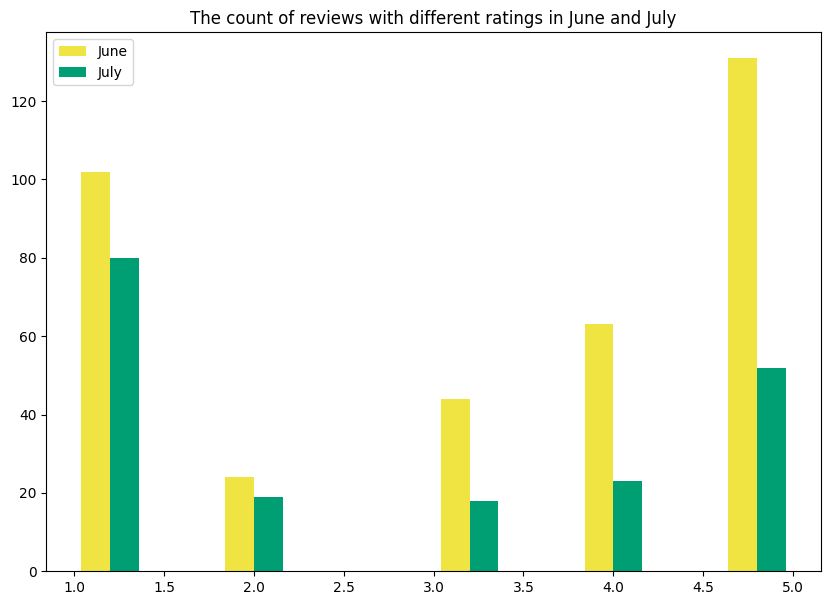

In [333]:
x3 = list(data[data['month'] == 'June']['rating'])
x4 = list(data[data['month'] == 'July']['rating'])

colors = ['#F0E442', '#009E73']
names = ['June', 'July']

plt.figure(figsize=(10, 7))
plt.title('The count of reviews with different ratings in June and July')
plt.hist([x3, x4], color = colors, label=names)
plt.legend()
plt.show()

**Interestingly, the number of positive reviews in July decreased by more than 2 times**

## Lemmatization and tokenization

In [169]:
# functions for preprosessing

def clean(text):
   clean_text = re.sub(r'[^a-zA-Z]', ' ', text)
   return clean_text

def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = []
    for token in text:
       token = lemmatizer.lemmatize(token)
       lemmatized_text.append(token)
    return lemmatized_text

def lemma_spacy(text):
  lemmatizer = spacy.load('en_core_web_sm')
  doc = lemmatizer(text)
  words_lemmas_list = [token.lemma_ for token in doc]
  return words_lemmas_list

def tokenize(text):
  tokenize_sentence = []
  for sentence in text:
    tokens = word_tokenize(sentence)
    tokenize_sentence.extend(tokens)
  return tokenize_sentence

def remove_stopwords(text):
    return [word for word in text if word not in stopwords and word.isalpha()]

In [170]:
data['review']=data['review'].apply(lambda x: x.lower())

In [171]:
# let's clear the reviews from emojis

data['review'] = data['review'].progress_apply(clean)

  0%|          | 0/2292 [00:00<?, ?it/s]

In [ ]:
# lemmatization
data['review'] = data['review'].progress_apply(lemma_spacy)

In [173]:
extra_words = ['chatgpt', 'gpt', 'point', 'app', 'eg', 'open', 'ai', 'please', 'ui', 'could', 'would', 'ect', 'chat', '`', 'n', 'a', 'the', 'no', 'first', 'second', 'third', ' ', 'nt', 'do', 'lot', 'io', 'I', 'pro', 'max']
stop = nltk_stopwords.words('english')
stopwords = set(stop + extra_words)

In [174]:
# clean data from stopwords and punctuation mark

data['review'] = data['review'].progress_apply(remove_stopwords)

  0%|          | 0/2292 [00:00<?, ?it/s]

## Frequency analysis


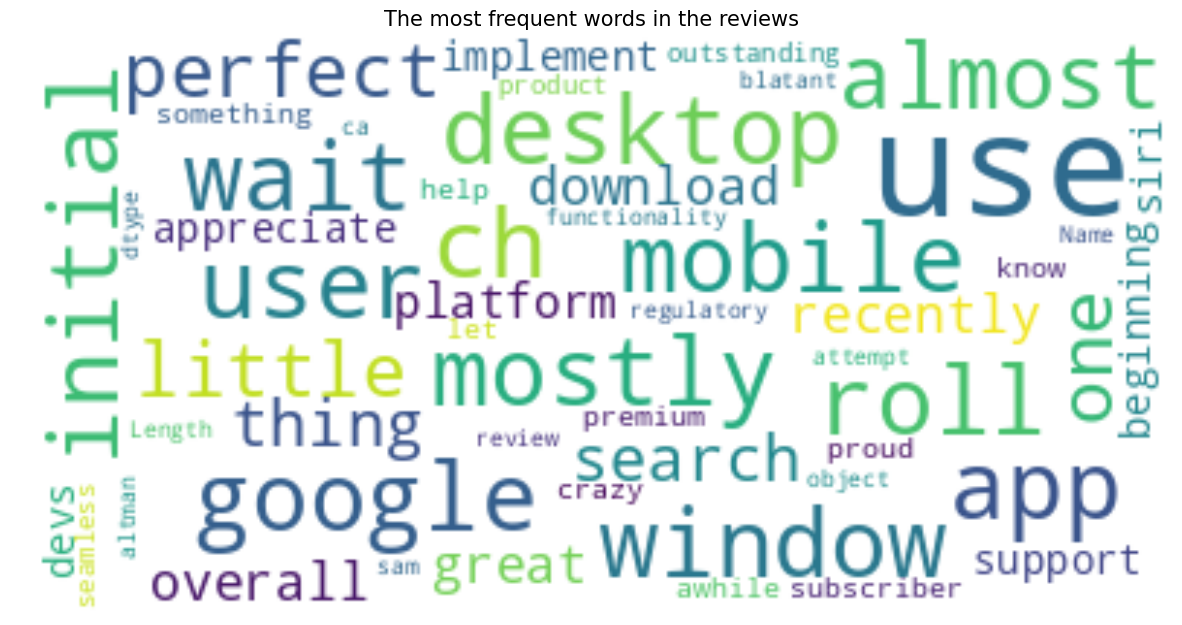

In [255]:
# create wordcloud

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(data['review']))
plt.figure(figsize = (15, 15))
plt.title('The most frequent words in the reviews', fontsize=15)
print()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [301]:
def freq_words(data, rating):
  #data = data.query('rating == rating').review
  list_word = []
  for row in data:
    list_word.extend(row)

  freq_words = FreqDist(list_word)
  print(f'                         The most frequent words in the comments with a rating of {rating}')
  plt.figure(figsize=(10, 5));
  freq_words.plot(20);


def freq_grams(data, rating):
  list_word = []
  for row in data:
    list_word.extend(row)
  list_n_grams = list(ngrams(list_word, 3))

  grams_series = (pd.Series(list_n_grams)).value_counts()[:20]
  grams_top = pd.DataFrame(grams_series.sort_values(ascending=False))
  grams_top = grams_top.reset_index().rename(columns={'index': f'trigrams {rating}', 0: f'counts {rating}'})
  return(grams_top)

def freq_bigrams_visualization(data, rating):
  grams_top = freq_grams(data, rating)
  sns.catplot(x = f'counts {rating}', y=f'trigrams {rating}', kind="bar", palette="vlag", data=grams_top, height=8.27, aspect=11.7/8.27);

In [257]:
review_1 = data.query('rating == 1').review
review_2 = data.query('rating == 2').review
review_3 = data.query('rating == 3').review
review_4 = data.query('rating == 4').review
review_5 = data.query('rating == 5').review

                         The most frequent words in the comments with a rating of 5


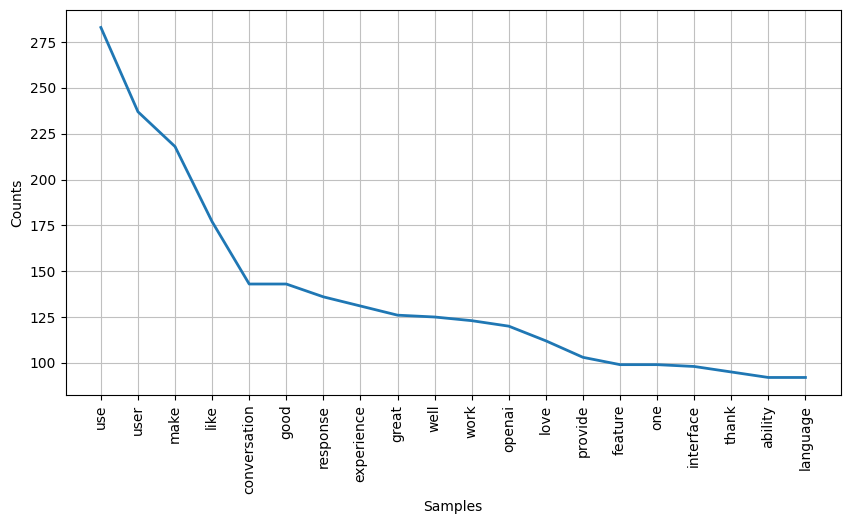

                         The most frequent words in the comments with a rating of 1


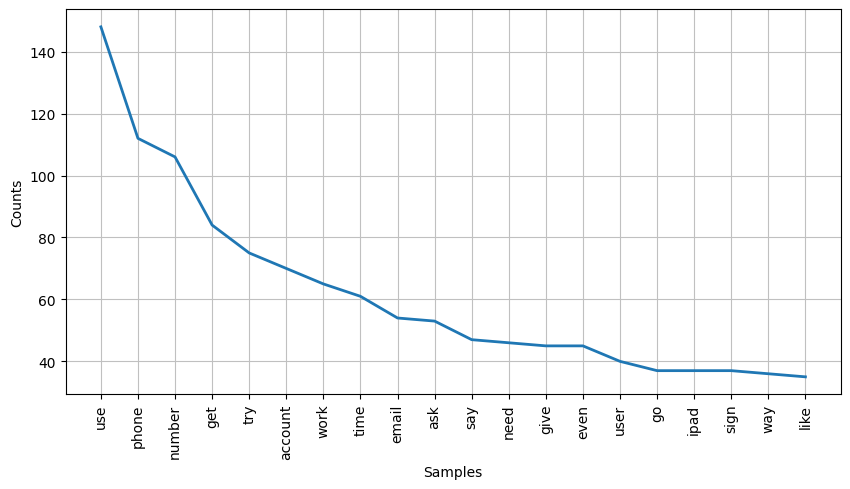

In [295]:
# how do words differ in reviews with a rating of 1 and with a rating of 5

freq_words(review_5, 5)

freq_words(review_1, 1)

**it seems that bad reviews are related to the technical side of the issue, so there are words ("email", "phone", "try", "number", "account" etc). In the top 20 of the five-point reviews, these words are generally absent.**

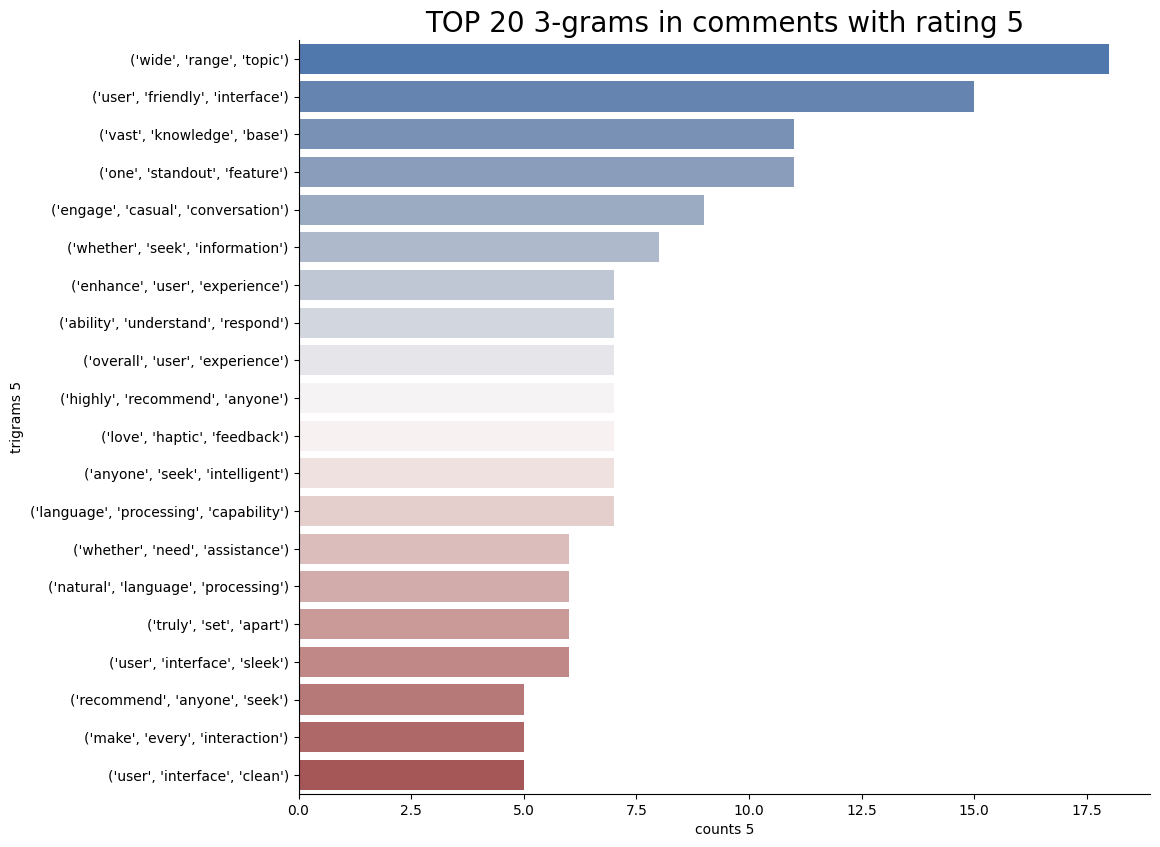

In [302]:
freq_bigrams_visualization(review_5, 5)
plt.title('TOP 20 3-grams in comments with rating 5', fontsize=20);

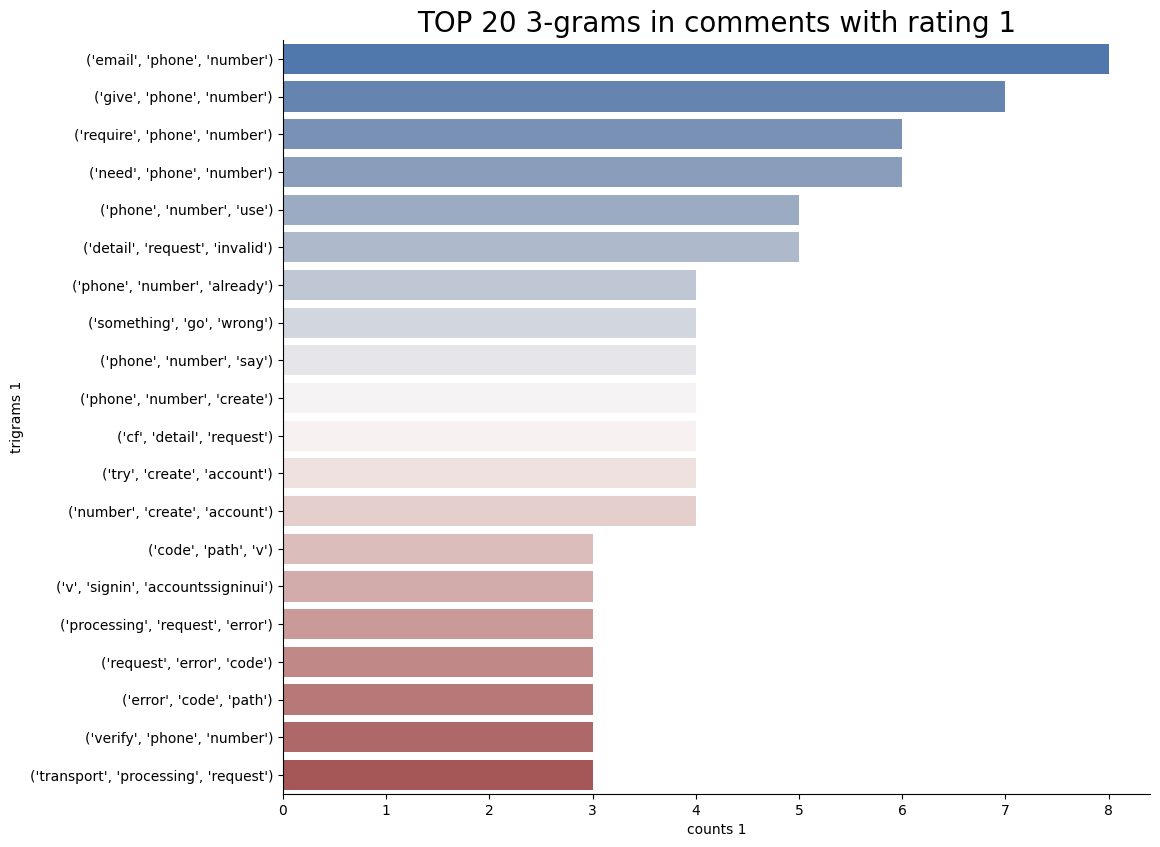

In [303]:
freq_bigrams_visualization(review_1, 1)
plt.title('TOP 20 3-grams in comments with rating 1', fontsize=20);

In [305]:
# table of trigrams for each category

final_table = pd.concat([freq_grams(review_1, 1), freq_grams(review_2, 2), freq_grams(review_3, 3), freq_grams(review_4, 4), freq_grams(review_5, 5)], axis=1)

pandas.core.frame.DataFrame

In [310]:
final_table = final_table.rename(columns={
    'trigrams 1': 'reviews_rating_1',
    'trigrams 2': 'reviews_rating_2',
    'trigrams 3': 'reviews_rating_3',
    'trigrams 4': 'reviews_rating_4',
    'trigrams 5': 'reviews_rating_5',
})

In [312]:
display(final_table)

,reviews_rating_1,counts 1,reviews_rating_2,counts 2,reviews_rating_3,counts 3,reviews_rating_4,counts 4,reviews_rating_5,counts 5
0,"(email, phone, number)",8,"(make, iphone, hot)",2,"(phone, get, hot)",6,"(enhance, user, experience)",5,"(wide, range, topic)",18
1,"(give, phone, number)",7,"(affordance, plugin, exist)",2,"(web, base, version)",4,"(session, web, browsing)",4,"(user, friendly, interface)",15
2,"(require, phone, number)",6,"(use, web, version)",2,"(cf, detail, request)",3,"(release, ipad, version)",3,"(vast, knowledge, base)",11
3,"(need, phone, number)",6,"(thu, th, p)",2,"(phone, start, heat)",3,"(button, top, right)",3,"(one, standout, feature)",11
4,"(phone, number, use)",5,"(iphone, become, hot)",2,"(lack, ipad, version)",2,"(phone, get, really)",3,"(engage, casual, conversation)",9
5,"(detail, request, invalid)",5,"(email, provide, support)",2,"(use, make, phone)",2,"(look, forward, see)",3,"(whether, seek, information)",8
6,"(phone, number, already)",4,"(hot, battery, drain)",2,"(handful, load, scroll)",2,"(ipad, ipad, ipad)",3,"(enhance, user, experience)",7
7,"(something, go, wrong)",4,"(freeze, time, despite)",1,"(use, browse, plugin)",2,"(email, subscription, load)",2,"(ability, understand, respond)",7
8,"(phone, number, say)",4,"(make, difficult, copy)",1,"(wait, handful, load)",2,"(portrait, landscape, mode)",2,"(overall, user, experience)",7
9,"(phone, number, create)",4,"(hide, history, really)",1,"(user, friendly, experience)",2,"(great, eye, sight)",2,"(highly, recommend, anyone)",7


# Conclusion


I conducted a frequency analysis of the text by highlighting the most popular trigramms found in reviews.


Reviews with a rating of 1 and 5 are more differentiable. This is explained by the fact that people who wrote bad reviews faced similar problems. The difference between 2 and 3, 3 and 4 categories is not so obvious.

**5 points were given for:**

- convenient interface

-  access to extensive information

- the ability to process natural language

- for understanding the query

**1 points were given for:**

-  the complexity of interacting with the product from the phone

- errors in requests

*I think the bad reviews are due to the inability to access all the functionality of the product, due to the lack of the ability to log in*

Reviews of the 2nd, 3rd and 4th categories from those who still managed to get access to the product.

**The rating of 2 was most affected by:**
-  the heating of the phone's battery during use. This thought occurs several times in different formulations ((*make, iphone, hot*), (*iphone, become, hot*), (*hot, battery, drain*)).

**Users who have set 3 points are also:**

-  not satisfied with the strong heating of the phone battery, but also in this group there are unique pozitive trigrams ((scroll, wait, handy), ((handy, load, scroll))

- not satisfied with the iPad version

**For users who set 4 points**, the heating of the battery is not as significant as for people from groups 2 and 3. But they encountered

-  a product freeze.

Although, they also note the indisputable advantages: *(forward, see, future)*, *(voiceover, screen, reader)*, *(haptic, feedback, nice)*.